In [1]:
# Cell 1: Imports & Data Download
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib as plt

In [2]:
# Define tickers and date range
tickers = ['TCS.NS', 'INFY.NS', 'NIFTYBEES.NS']
start_date = '2024-06-01'
end_date   = '2025-06-01'


In [3]:
# grabbing the data and having the raw
raw = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,   # keep raw OHLC
    progress=False
)

# Peek at the first few rows & columns
raw.head(), raw.columns

(Price         Adj Close                                  Close               \
 Ticker          INFY.NS NIFTYBEES.NS       TCS.NS      INFY.NS NIFTYBEES.NS   
 Date                                                                          
 2024-06-03  1370.785400   258.140015  3644.127441  1405.900024   258.140015   
 2024-06-04  1358.841309   250.479996  3656.084961  1393.650024   250.479996   
 2024-06-05  1394.380859   251.300003  3687.035889  1430.099976   251.300003   
 2024-06-06  1435.478271   252.979996  3769.654541  1472.250000   252.979996   
 2024-06-07  1495.295776   258.420013  3832.197021  1533.599976   258.420013   
 
 Price                           High                                    Low  \
 Ticker           TCS.NS      INFY.NS NIFTYBEES.NS       TCS.NS      INFY.NS   
 Date                                                                          
 2024-06-03  3702.850098  1440.000000   265.000000  3751.550049  1404.000000   
 2024-06-04  3715.000000  1415.000000 

In [5]:
# Now pull in the auto-adjusted series in isolation
adj = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    auto_adjust=True,    # shifts ‘Close’ to be adjusted-close
    progress=False
)['Close']  # this is now the adjusted-close

# Save it for record
adj.to_csv('../data/prices.csv')

# Confirm
adj.head()

Ticker,INFY.NS,NIFTYBEES.NS,TCS.NS
Date,,,
2024-06-03,1370.785400,258.140015,3644.127441
2024-06-04,1358.841309,250.479996,3656.084961
2024-06-05,1394.380859,251.300003,3687.035889
2024-06-06,1435.478271,252.979996,3769.654541
2024-06-07,1495.295776,258.420013,3832.197021


In [6]:
# Cell 5: daily returns
returns = adj.pct_change().dropna()
returns.head()


Ticker,INFY.NS,NIFTYBEES.NS,TCS.NS
Date,,,
2024-06-04,-0.008713,-0.029674,0.003281
2024-06-05,0.026154,0.003274,0.008466
2024-06-06,0.029474,0.006685,0.022408
2024-06-07,0.041671,0.021504,0.016591
2024-06-10,-0.022072,-0.001857,-0.009053


In [7]:
# Annualized mean returns & covariance
mu = returns.mean() * 252       # ~252 trading days
Sigma = returns.cov()  * 252

print("Annualized Returns (μ):\n", mu.round(4))
print("\nAnnualized Covariance (Σ):\n", Sigma.round(4))


Annualized Returns (μ):
 Ticker
INFY.NS         0.1681
NIFTYBEES.NS    0.0844
TCS.NS         -0.0371
dtype: float64

Annualized Covariance (Σ):
 Ticker        INFY.NS  NIFTYBEES.NS  TCS.NS
Ticker                                     
INFY.NS        0.0679        0.0194  0.0422
NIFTYBEES.NS   0.0194        0.0172  0.0150
TCS.NS         0.0422        0.0150  0.0486


In [11]:
# Cell 7: Simulate random portfolios and compute return, risk, Sharpe
import numpy as np
import pandas as pd

# how many portfolios to try
num_portfolios = 5000

# lists to store our results
port_returns = []  # will hold expected returns
port_vols    = []  # will hold volatilities
port_sharpes = []  # will hold Sharpe ratios
port_weights = []  # keep the weight vectors if we need them

# risk free rate (annual)
rf = 0.0

# loop over random portfolios
for i in range(num_portfolios):
    # make random weights that sum to 1
    weights = np.random.random(len(mu))
    weights /= np.sum(weights)
    
    # calculate portfolio return
    ret = np.dot(weights, mu)  # weighted average of expected returns
    # calculate portfolio variance then volatility
    var = np.dot(weights.T, np.dot(Sigma, weights))
    vol = np.sqrt(var)
    # calculate Sharpe (assume rf=0)
    sharpe = (ret - rf) / vol
    
    # save the results
    port_returns.append(ret)
    port_vols.append(vol)
    port_sharpes.append(sharpe)
    port_weights.append(weights)

# make a DataFrame with all the results
simulations = pd.DataFrame({
    'Return': port_returns,
    'Volatility': port_vols,
    'Sharpe': port_sharpes
})

# show the top few simulated portfolios
simulations.head()
simulations.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Return      5000 non-null   float64
 1   Volatility  5000 non-null   float64
 2   Sharpe      5000 non-null   float64
dtypes: float64(3)
memory usage: 117.3 KB


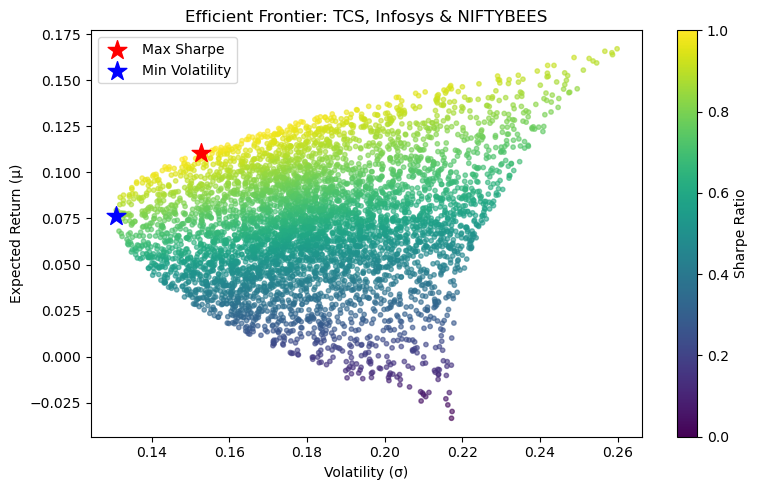

In [12]:
# Cell 8: Plot the Efficient Frontier
import matplotlib.pyplot as plt

# find the portfolio with max Sharpe and min Volatility
max_sharpe_idx = simulations['Sharpe'].idxmax()
min_vol_idx    = simulations['Volatility'].idxmin()

# get those points
max_sharpe_ret = simulations.loc[max_sharpe_idx, 'Return']
max_sharpe_vol = simulations.loc[max_sharpe_idx, 'Volatility']
min_vol_ret    = simulations.loc[min_vol_idx, 'Return']
min_vol_vol    = simulations.loc[min_vol_idx, 'Volatility']

# start plotting
plt.figure(figsize=(8,5))

# scatter all the portfolios, color by Sharpe ratio
# using scatter(x, y, c=, cmap=)
plt.scatter(
    simulations['Volatility'],
    simulations['Return'],
    c=simulations['Sharpe'],
    cmap='viridis',   # beginner use of a colormap
    marker='o',
    s=10,             # small circles
    alpha=0.6
)

# highlight max Sharpe point in red
plt.scatter(
    max_sharpe_vol,
    max_sharpe_ret,
    marker='*',
    color='r',
    s=200,
    label='Max Sharpe'
)

# highlight min Volatility point in blue
plt.scatter(
    min_vol_vol,
    min_vol_ret,
    marker='*',
    color='b',
    s=200,
    label='Min Volatility'
)

# labels and title
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return (μ)')
plt.title('Efficient Frontier: TCS, Infosys & NIFTYBEES')
plt.legend()

# add a colorbar
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')

# save the figure
plt.tight_layout()
plt.savefig('../results/efficient_frontier.png')

# show it
plt.show()
